##**Predictive Analytics of COVID-19 cases in Indonesia**

Group:
1.   Gabriella Christina Kandinata;
2.   Muhammad Arkan Alireza;
3.   Muhammad Yusuf Daffa Izzalhaqqi

In [ ]:
!pip install jcopml

     |████████████████████████████████| 102kB 6.2MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.10-py2.py3-none-any.whl size=33230 sha256=1c908748aacc0a0a7930748c4b946b6aa8fc1c69a50e4182c9f765b0041c5931
  Stored in directory: /root/.cache/pip/wheels/82/22/ce/b8b4c3400f788e5050b5b4b4d988884b8ec72b6b8751693914
Successfully built jcopml


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from jcopml.plot import plot_actual_vs_prediction, plot_residual

In [ ]:
df = pd.read_excel('Dataset_Covid_UPDATED.xlsx', 'All')
df.head()

,Date,Cumulative_Confirmed_Cases,Daily_Confirmed_Cases,Daily_Recovered_Cases,Daily_Death_Cases,Province
0,2020-03-15,NaN,19.0,NaN,NaN,DKI Jakarta
1,2020-03-15,NaN,NaN,NaN,NaN,Jawa Barat
2,2020-03-15,NaN,2.0,NaN,NaN,Jawa Tengah
3,2020-03-15,NaN,NaN,NaN,NaN,Jawa Timur
4,2020-03-15,NaN,NaN,NaN,NaN,Yogyakarta


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2005 entries, 0 to 2004
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        2005 non-null   datetime64[ns]
 1   Cumulative_Confirmed_Cases  1990 non-null   float64       
 2   Daily_Confirmed_Cases       1955 non-null   float64       
 3   Daily_Recovered_Cases       1853 non-null   float64       
 4   Daily_Death_Cases           1579 non-null   float64       
 5   Province                    2005 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 94.1+ KB


EDA

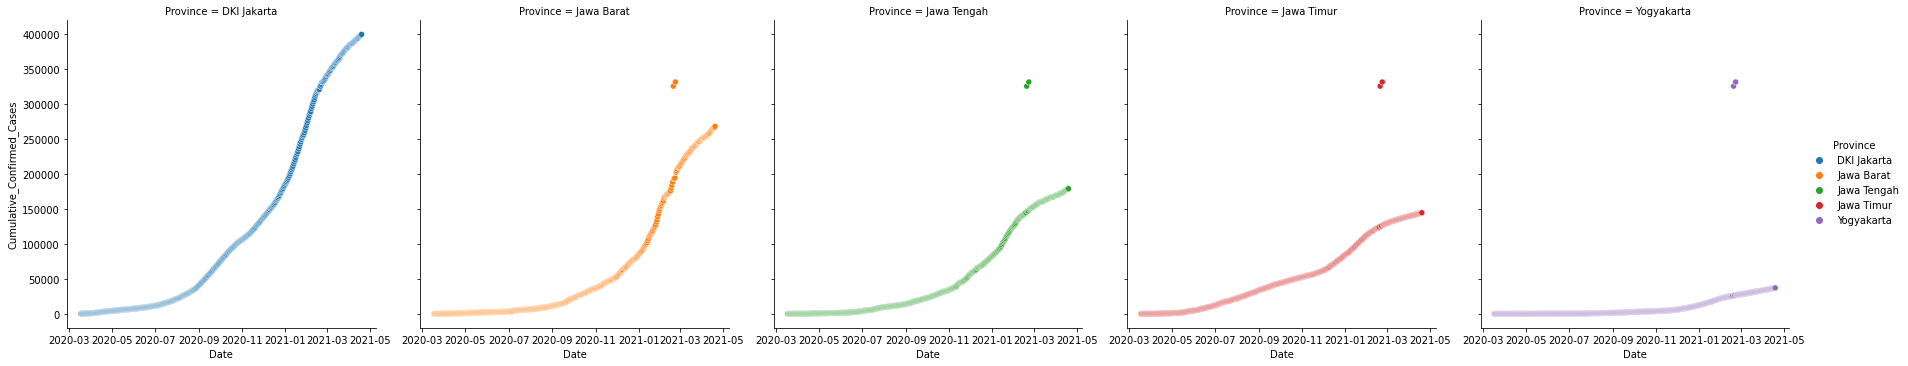

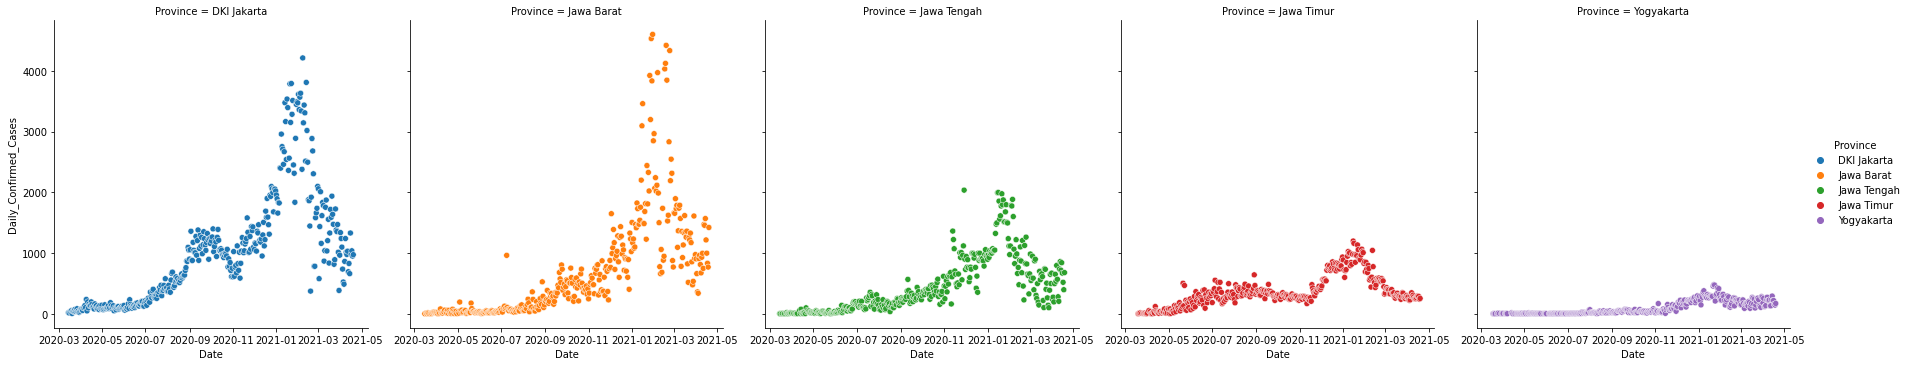

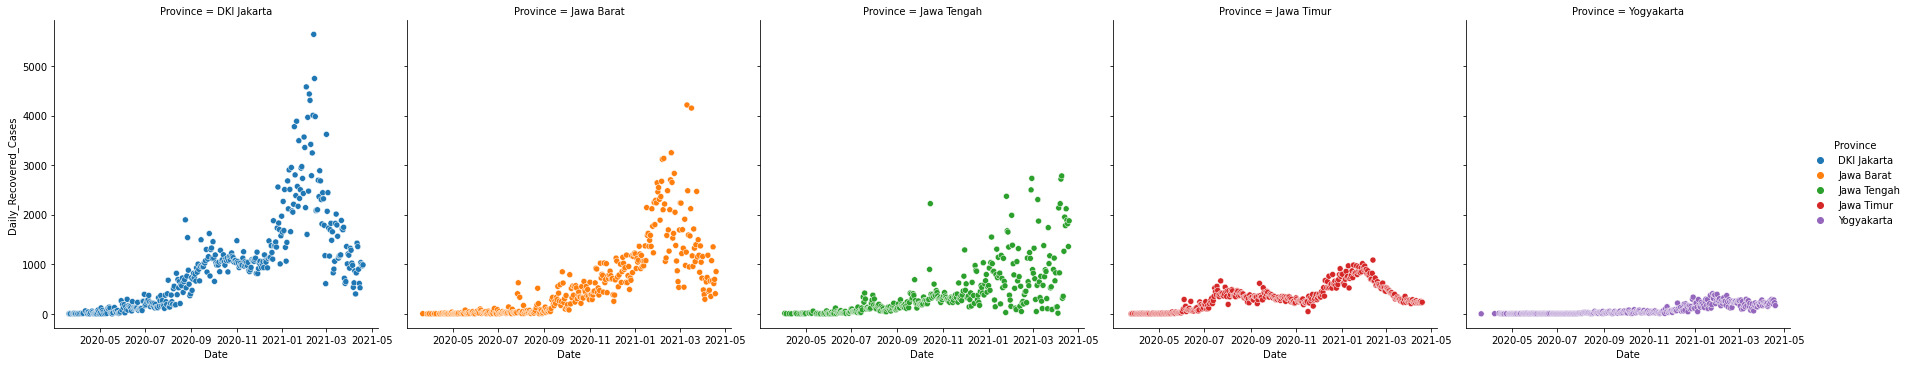

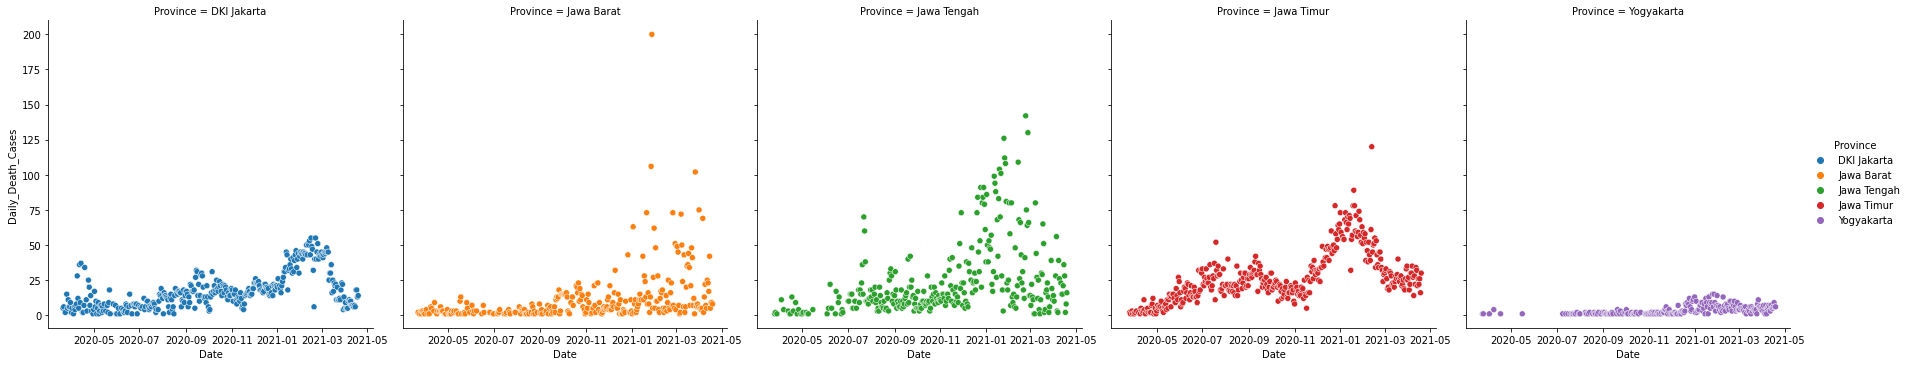

In [ ]:
#Display the visualization between the columns of interest with respect to the date
col_of_interest = ['Cumulative_Confirmed_Cases', 'Daily_Confirmed_Cases', 'Daily_Recovered_Cases', 'Daily_Death_Cases']
for col in col_of_interest:
  sns.relplot(x='Date', y=col, data=df, hue="Province", col="Province", col_wrap=5)

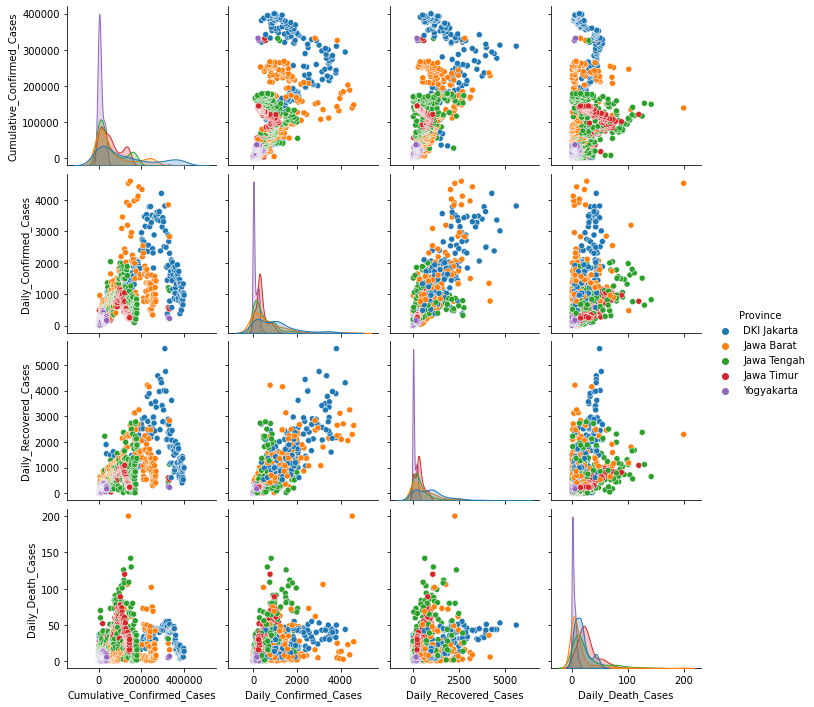

In [ ]:
#Display the pairwise relationships between the float variables
sns.pairplot(df, hue='Province')

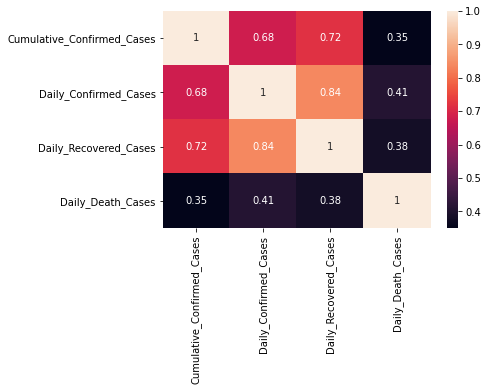

In [ ]:
#Display the correlation between the float variables
sns.heatmap(df.corr(), annot=True)

Mini EDA for ML

In [ ]:
df.drop(columns=['Date'], inplace=True)

,missing_value,%
Cumulative_Confirmed_Cases,15,0.75
Daily_Confirmed_Cases,50,2.49
Daily_Recovered_Cases,152,7.58
Daily_Death_Cases,426,21.25
Province,0,0.00


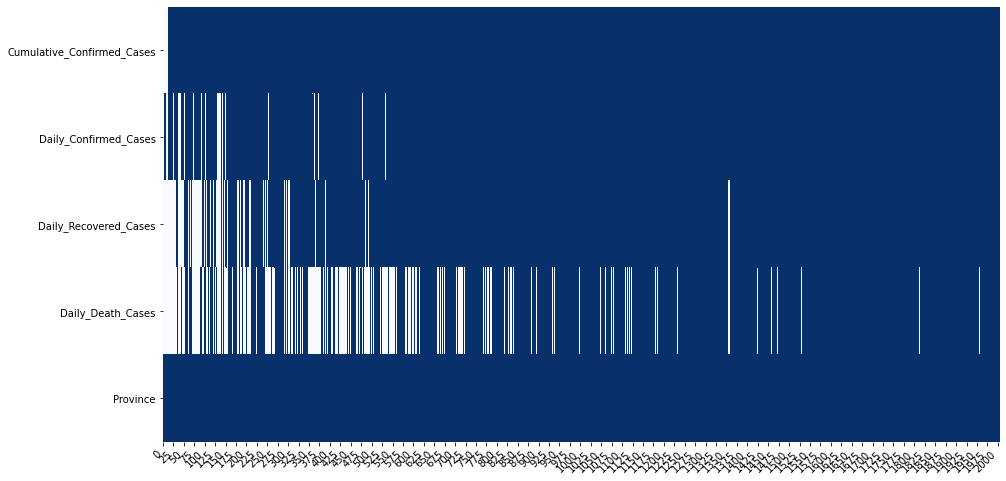

In [ ]:
plot_missing_value(df, return_df=True)

Data Splitting

In [ ]:
X = df.drop(columns='Daily_Recovered_Cases')
y = df.Daily_Recovered_Cases

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1604, 4), (401, 4), (1604,), (401,))

In [ ]:
df = df.replace(np.nan, df.mean())

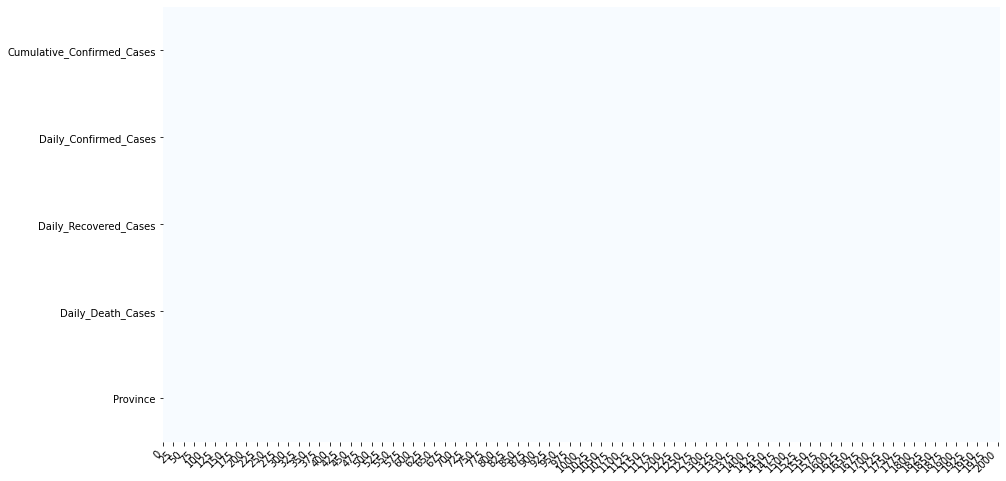

In [ ]:
plot_missing_value(df)

# Simple Model

Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["Cumulative_Confirmed_Cases", 'Daily_Confirmed_Cases', 'Daily_Death_Cases']),
    ('categoric', cat_pipe(encoder='onehot'), ['Province']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])


model = GridSearchCV(pipeline, gsp.linreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'algo__fit_intercept': True}
0.7265885223113968 0.7243968584092375 0.7108461526156682


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished


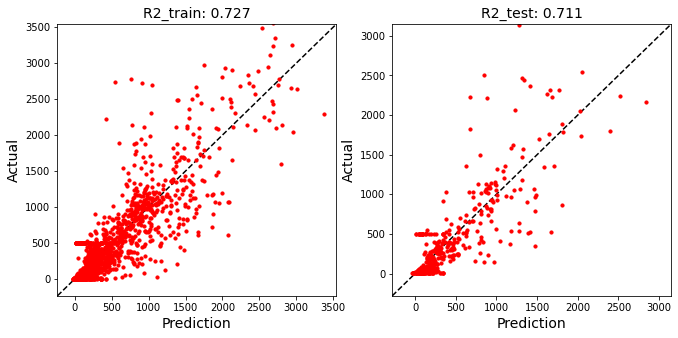

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


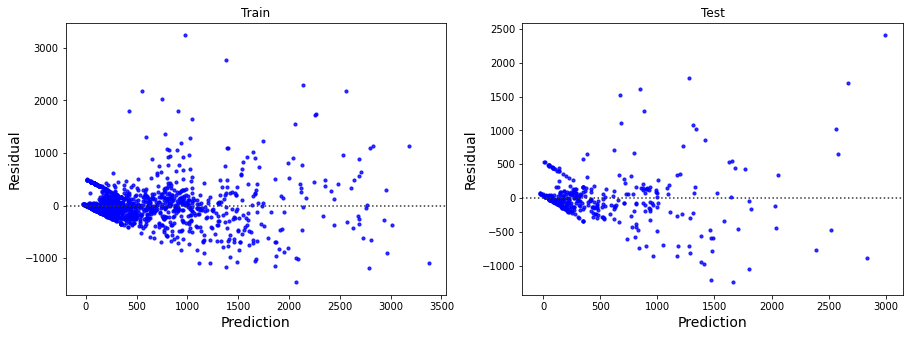

In [ ]:
plot_residual(X_train, y_train, X_test, y_test, model)

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ["Cumulative_Confirmed_Cases", 'Daily_Confirmed_Cases', 'Daily_Death_Cases']),
    ('categoric', cat_pipe(encoder='onehot'), ['Province']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])


model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
0.7495145355993997 0.7398415169439471 0.7450378305779024


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.7s finished


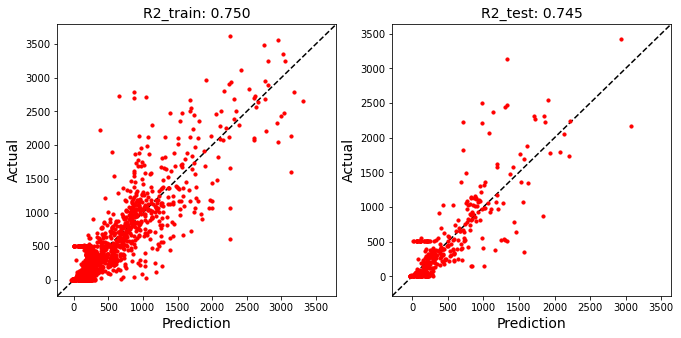

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


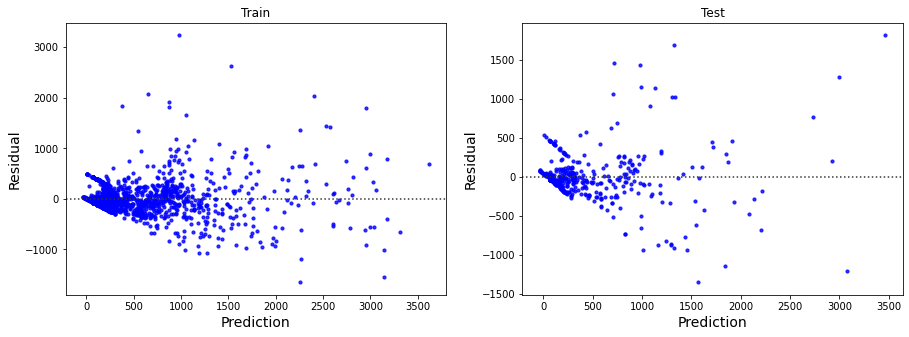

In [ ]:
plot_residual(X_train, y_train, X_test, y_test, model)

In [ ]:
#scaling ga scaling sm aja
preprocessor = ColumnTransformer([
     ('numeric', num_pipe(poly=2,  scaling='minmax'), ["Cumulative_Confirmed_Cases", 'Daily_Confirmed_Cases', 'Daily_Death_Cases']),
    ('categoric', cat_pipe(encoder='onehot'), ['Province']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

model = GridSearchCV(pipeline, gsp.linreg_poly_params , cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


{'algo__fit_intercept': False, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
0.7495145355993997 0.7398415169431276 0.7450378305770167


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.7s finished


# Feature Importance

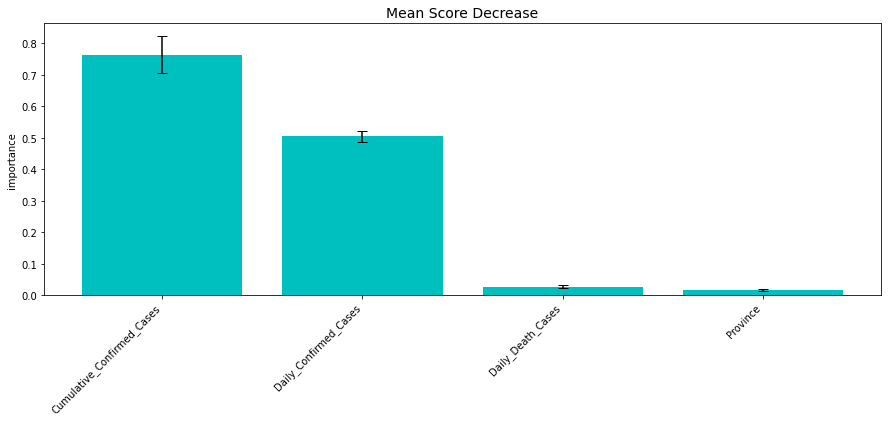

In [ ]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

# **Other Models**

KNN

In [ ]:
preprocessor = ColumnTransformer([
  ('numeric', num_pipe(scaling='minmax'), ['Cumulative_Confirmed_Cases', 'Daily_Confirmed_Cases', 'Daily_Death_Cases']),
    ('categoric', cat_pipe(encoder='onehot'), ["Province"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsRegressor())
])


model = RandomizedSearchCV(pipeline, rsp.knn_params, cv=3, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)


print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s finished


{'algo__n_neighbors': 21, 'algo__p': 1.6174815096277166, 'algo__weights': 'distance'}
0.9999999779283123 0.778962864550237 0.7818988295530062


In [ ]:
preprocessor = ColumnTransformer([
  ('numeric', num_pipe(scaling='minmax'), ['Cumulative_Confirmed_Cases', 'Daily_Confirmed_Cases', 'Daily_Death_Cases']),
    ('categoric', cat_pipe(encoder='onehot'), ["Province"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsRegressor())
])


model = GridSearchCV(pipeline, gsp.knn_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.2s


{'algo__n_neighbors': 9, 'algo__p': 1, 'algo__weights': 'distance'}
0.9999999779283123 0.7858084131633077 0.7798575103677478


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    7.3s finished


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
preprocessor = ColumnTransformer([
  ('numeric', num_pipe(), ['Cumulative_Confirmed_Cases', 'Daily_Confirmed_Cases', 'Daily_Death_Cases']),
    ('categoric', cat_pipe(encoder='onehot'), ["Province"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])


model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)



print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.2s finished


{'algo__max_depth': 30, 'algo__max_features': 0.5133240027692805, 'algo__min_samples_leaf': 4, 'algo__n_estimators': 123}
0.8840184524684883 0.7919021100477611 0.8009034952376008


In [ ]:
preprocessor = ColumnTransformer([
  ('numeric', num_pipe(), ['Cumulative_Confirmed_Cases', 'Daily_Confirmed_Cases', 'Daily_Death_Cases']),
    ('categoric', cat_pipe(encoder='onehot'), ["Province"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)



print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  1.2min finished


{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 100}
0.8685774866577106 0.7923987480898421 0.7942090853549794


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   23.0s finished


{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 10, 'algo__n_estimators': 200}
0.8350710449005857 0.7819612706103941 0.7806269538805234


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


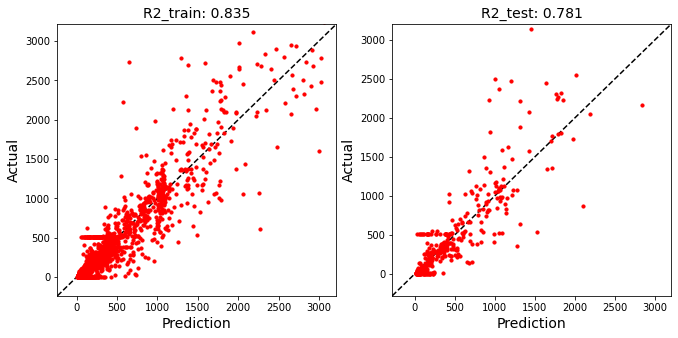

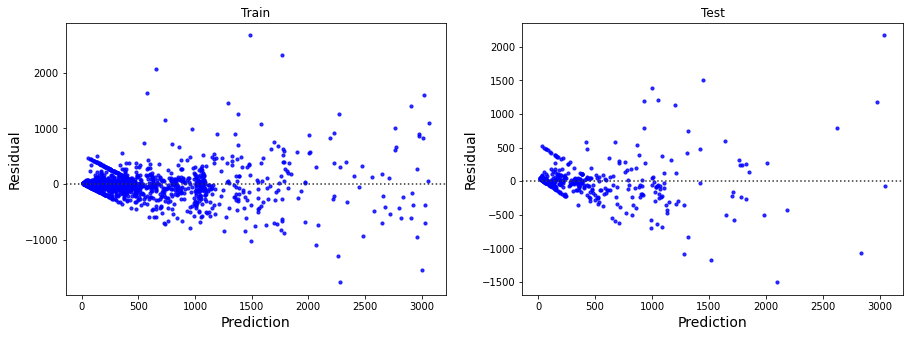

In [ ]:
preprocessor = ColumnTransformer([
  ('numeric', num_pipe(), ['Cumulative_Confirmed_Cases', 'Daily_Confirmed_Cases', 'Daily_Death_Cases']),
    ('categoric', cat_pipe(encoder='onehot'), ["Province"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

parameter={'algo__n_estimators': [150, 200, 250],
 'algo__max_depth': [20, 30],
 'algo__max_features': [0.3, 0.6],
 'algo__min_samples_leaf': [10, 15]}


model = GridSearchCV(pipeline, parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)



print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)
plot_residual(X_train, y_train, X_test, y_test, model)

XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
preprocessor = ColumnTransformer([
  ('numeric', num_pipe(), ['Cumulative_Confirmed_Cases', 'Daily_Confirmed_Cases', 'Daily_Death_Cases']),
    ('categoric', cat_pipe(encoder='onehot'), ["Province"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.6s finished


[16:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'algo__colsample_bytree': 0.5261245937025092, 'algo__gamma': 1, 'algo__learning_rate': 0.08498604636076731, 'algo__max_depth': 5, 'algo__n_estimators': 122, 'algo__reg_alpha': 0.0015568103018717575, 'algo__reg_lambda': 6.2601238645330595, 'algo__subsample': 0.7433401936490238}
0.904091007806298 0.7855895317467297 0.8031986620305496


In [ ]:
preprocessor = ColumnTransformer([
  ('numeric', num_pipe(poly=2), ['Cumulative_Confirmed_Cases', 'Daily_Confirmed_Cases', 'Daily_Death_Cases']),
    ('categoric', cat_pipe(encoder='onehot'), ["Province"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[16:38:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'algo__colsample_bytree': 0.6069593960609854, 'algo__gamma': 10, 'algo__learning_rate': 0.040665633135147955, 'algo__max_depth': 5, 'algo__n_estimators': 101, 'algo__reg_alpha': 0.5456725485601479, 'algo__reg_lambda': 0.05762487216478603, 'algo__subsample': 0.3610191174223894, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}
0.8859509947250782 0.777128670703501 0.7963906459142546


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


In [ ]:
preprocessor = ColumnTransformer([
  ('numeric', num_pipe(poly=2), ['Cumulative_Confirmed_Cases', 'Daily_Confirmed_Cases', 'Daily_Death_Cases']),
    ('categoric', cat_pipe(encoder='onehot'), ["Province"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

parameter={'algo__max_depth': [3, 6, 10],
 'algo__colsample_bytree': [0.4, 0.6, 0.8],
 'algo__n_estimators': [150, 200, 250],
 'algo__subsample': [0.4, 0.6, 0.8],
 'algo__gamma': [1, 5, 10],
 'algo__learning_rate': [0.01, 0.1],
 'algo__reg_alpha': [0.01, 0.1, 10],
 'algo__reg_lambda': [0.01, 0.1, 10]}

model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.3s finished


[06:19:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'algo__colsample_bytree': 0.6069593960609854, 'algo__gamma': 10, 'algo__learning_rate': 0.040665633135147955, 'algo__max_depth': 5, 'algo__n_estimators': 101, 'algo__reg_alpha': 0.5456725485601479, 'algo__reg_lambda': 0.05762487216478603, 'algo__subsample': 0.3610191174223894, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}
0.8859509947250782 0.777128670703501 0.7963906459142546
